# Data Wrangling #2:  MIMIC III Database

## Data Source 

For this project, I used publicly available Electronic Health Records (EHRs) datasets. The MIT Media Lab for Computational Physiology has developed MIMIC-IIIv1.4 dataset based on 46,520 patients who stayed in critical care units of the Beth Israel Deaconess Medical Center of Boston between 2001 and 2012. MIMIC-IIIv1.4 dataset is freely available to researchers across the world. A formal request should be made directly to www.mimic.physionet.org, to gain acess to the data. There is a required course on human research ‘Data or Specimens Only Research’ prior to data acess request. I have secured one here -www.citiprogram.org/verify/?kb6607b78-5821-4de5-8cad-daf929f7fbbf-33486907

The dataset has 26 relational tables including patient’s hospital admission, callout information when patient was ready for discharge, caregiver information, electronic charted events including vital signs and any additional information relevant to patient care, patient demographic data, list of services the patient was admitted or transferred under,  ICU stay types, diagnoses types, laboratory measurments, microbiology tests and sensitivity, prescription data and billing information. 

Although I have full access to the MIMIC-IIIv1.4 datasets, I can not share any part of the data publicly. If you are interested to learn more about the data, there is a MIMIC III Demo dataset based on 100 patients https://mimic.physionet.org/gettingstarted/demo/. If you are interested to requesting access to the data - https://mimic.physionet.org/gettingstarted/access/. 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import csv
import re

In [4]:
os.getcwd()

'C:\\Users\\abebu\\Google Drive\\Abebual\\Capstone Project 1\\9. MIMIC III\\data_wrangling'

In [4]:
os.chdir("C://Users/abebu/Google Drive/mimic-iii-clinical-database-1.4/output")

### Working Dataset 1: ICU Stays 
icu_stays dataframe or icu_stays_5k.CSV includes an ICU stays of randomly sampled 5000 patients and merged between the following tables:
+ PATIENTS.csv
+ ADMISSIONS.csv
+ SERVICES.csv
+ DIAGNOSES_ICD.csv
+ D_ICD_DIAGNOSES.csv
+ ICUSTAYS

Now I would like to narrow down to the final model variables of  interest (this include adding, removing and transforming columns). 

In [6]:
#read ICU Stays dataset as pandas dataframe.
stays_5k=pd.read_csv('icu_stays_5k.csv', header=0, index_col=0)
stays_5k.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105845 entries, 0 to 105844
Data columns (total 32 columns):
SUBJECT_ID        105845 non-null int64
GENDER            105845 non-null object
DOB               105845 non-null object
DOD               52570 non-null object
DOD_HOSP          39036 non-null object
DOD_SSN           41722 non-null object
EXPIRE_FLAG       105845 non-null int64
HADM_ID           105845 non-null int64
ADMITTIME         105845 non-null object
DISCHTIME         105845 non-null object
DEATHTIME         18122 non-null object
ETHNICITY         105845 non-null object
MARITAL_STATUS    96850 non-null object
ADMISSION_TYPE    105845 non-null object
INSURANCE         105845 non-null object
ICUSTAY_ID        104840 non-null float64
DBSOURCE          104840 non-null object
FIRST_CAREUNIT    104840 non-null object
LAST_CAREUNIT     104840 non-null object
FIRST_WARDID      104840 non-null float64
LAST_WARDID       104840 non-null float64
INTIME            104840 non-null

In [64]:
# List all the columns for a brief view - also in my work i find it easy to directly copy and paste column names. 
list(stays_5k)

['SUBJECT_ID',
 'GENDER',
 'DOB',
 'DOD',
 'DOD_HOSP',
 'DOD_SSN',
 'EXPIRE_FLAG',
 'HADM_ID',
 'ADMITTIME',
 'DISCHTIME',
 'DEATHTIME',
 'ETHNICITY',
 'MARITAL_STATUS',
 'ADMISSION_TYPE',
 'INSURANCE',
 'ICUSTAY_ID',
 'DBSOURCE',
 'FIRST_CAREUNIT',
 'LAST_CAREUNIT',
 'FIRST_WARDID',
 'LAST_WARDID',
 'INTIME',
 'OUTTIME',
 'LOS',
 'ADM_AGE',
 'SEQ_NUM',
 'ICD9_CODE',
 'SHORT_TITLE',
 'LONG_TITLE',
 'AGE',
 'PREV_SERVICE',
 'CURR_SERVICE']

In [65]:
# all datetime columns are 'object' data type, transform them to datetime. 
stays_5k.DOB = pd.to_datetime(stays_5k.DOB)
stays_5k.DOD = pd.to_datetime(stays_5k.DOD)
stays_5k.DOD_HOSP = pd.to_datetime(stays_5k.DOD_HOSP)
stays_5k.DOD_SSN = pd.to_datetime(stays_5k.DOD_SSN)
stays_5k.ADMITTIME = pd.to_datetime(stays_5k.ADMITTIME)
stays_5k.DISCHTIME = pd.to_datetime(stays_5k.DISCHTIME)
stays_5k.DEATHTIME = pd.to_datetime(stays_5k.DEATHTIME)
stays_5k.INTIME = pd.to_datetime(stays_5k.INTIME)
stays_5k.OUTTIME = pd.to_datetime(stays_5k.OUTTIME)

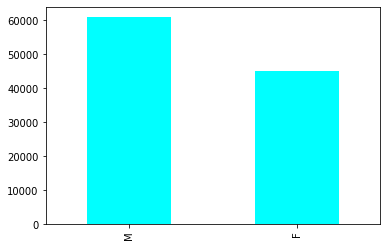

In [66]:
# Briefly visiualize 'GENDER' column values
stays_5k['GENDER'].value_counts().plot(kind='bar', color='cyan')

In [67]:
# map F, M gender values to 1 and 2.
g_map = {'F': 1, 'M': 2} 
stays_5k["GENDER"].replace(g_map, inplace=True)

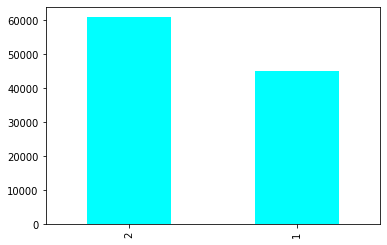

In [68]:
stays_5k["GENDER"].value_counts().plot(kind='bar', color='cyan')

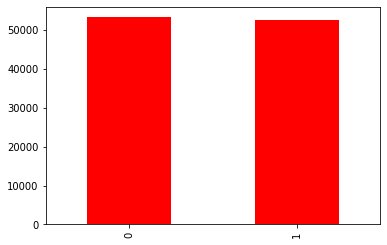

In [74]:
stays_5k['EXPIRE_FLAG'].value_counts().plot(kind='bar', color='red')

EXPIRE_FLAG is a binary flag which indicates whether the patient died, i.e.
whether DOD is null or not. These deaths include both deaths within the
hospital ( DOD_HOSP ) and deaths identified by matching the patient to the
social security master death index ( DOD_SSN ). We need to create EXPIRE_FLAG column that only flag death death within the hospital. 

In [75]:
#create EXPIRE_FLAG column that only flag in-hospital death. 
mortality = stays_5k.DOD.notnull() & ((stays_5k.ADMITTIME <= stays_5k.DOD) & (stays_5k.DISCHTIME >= stays_5k.DOD))
mortality = mortality | (stays_5k.DEATHTIME.notnull() & ((stays_5k.ADMITTIME <= stays_5k.DEATHTIME) & (stays_5k.DISCHTIME >= stays_5k.DEATHTIME)))
stays_5k['MORTALITY'] = mortality.astype(int)
stays_5k['MORTALITY_INHOSPITAL'] = stays_5k['MORTALITY']

In [76]:
#create EXPIRE_FLAG column that only flag death death during ICU stay. 
ICU_DEATH = stays_5k.DOD.notnull() & ((stays_5k.INTIME <= stays_5k.DOD) & (stays_5k.OUTTIME >= stays_5k.DOD))
ICU_DEATH = ICU_DEATH | (stays_5k.DEATHTIME.notnull() & ((stays_5k.INTIME <= stays_5k.DEATHTIME) & (stays_5k.OUTTIME >= stays_5k.DEATHTIME)))
stays_5k['ICU_DEATH'] = ICU_DEATH.astype(int)

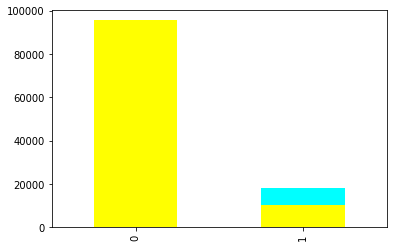

In [77]:
# visualize MORTALITY_INHOSPITAL (Cyan) and ICU_DEATH (yellow)
ax=stays_5k['MORTALITY_INHOSPITAL'].value_counts().plot(kind='bar', color='cyan')
stays_5k['ICU_DEATH'].value_counts().plot(kind='bar', color='yellow')

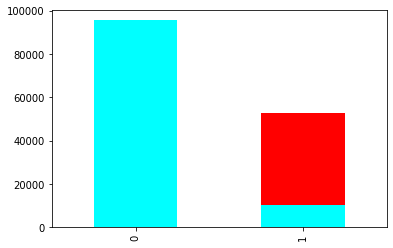

In [78]:
# visualize 'EXPIRE_FLAG' (Cyan) and ICU_DEATH (yellow)
ax=stays_5k['EXPIRE_FLAG'].value_counts().plot(kind='bar', color='red')
stays_5k['ICU_DEATH'].value_counts().plot(kind='bar', color='cyan')

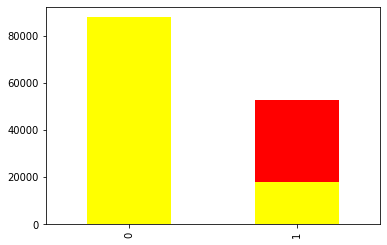

In [79]:
# visualize 'EXPIRE_FLAG' (red) and MORTALITY_INHOSPITAL (yellow)
ax=stays_5k['EXPIRE_FLAG'].value_counts().plot(kind='bar', color='red')
stays_5k['MORTALITY_INHOSPITAL'].value_counts().plot(kind='bar', color='yellow')

In [80]:
# remove ICU stays with transfers 
stays_5k = stays_5k.loc[(stays_5k.FIRST_WARDID == stays_5k.LAST_WARDID) & (stays_5k.FIRST_CAREUNIT == stays_5k.LAST_CAREUNIT)]
stays_5k.shape

(91119, 35)

In [81]:
# Only keep one ICU admission per Hospital admission  
keep_adm = stays_5k.groupby('HADM_ID').count()[['ICUSTAY_ID']].reset_index()
keep_adm = keep_adm.loc[(keep_adm.ICUSTAY_ID >= 1) & (keep_adm.ICUSTAY_ID <= 1)][['HADM_ID']]
stays_5k = stays_5k.merge(keep_adm, how='left', left_on='HADM_ID', right_on='HADM_ID')
stays_5k.shape

(91119, 35)

none (no ICU admission) were dropped as a result of the above action. 

In [82]:
#Remove any duplicates of SUBJECT_ID + HADM_ID + ICUSTAY_ID
stays_5k=stays_5k.drop_duplicates (subset=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'], keep='first')

In [83]:
stays_5k

,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,HADM_ID,ADMITTIME,DISCHTIME,...,SEQ_NUM,ICD9_CODE,SHORT_TITLE,LONG_TITLE,AGE,PREV_SERVICE,CURR_SERVICE,MORTALITY,MORTALITY_INHOSPITAL,ICU_DEATH
0,665,2,2052-05-20,2120-02-04,2120-02-04,NaT,1,126226,2114-07-05,2114-07-08 03:00:00,...,1.0,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,2269,NaN,CMED,0,0,0
5,665,2,2052-05-20,2120-02-04,2120-02-04,NaT,1,152089,2119-02-25,2119-02-27 20:53:00,...,1.0,4589,Hypotension NOS,"Hypotension, unspecified",24386,NaN,MED,0,0,0
20,665,2,2052-05-20,2120-02-04,2120-02-04,NaT,1,170157,2119-04-11,2119-06-03 15:57:00,...,1.0,56081,Intestinal adhes w obstr,Intestinal or peritoneal adhesions with obstru...,24464,NaN,MED,0,0,0
71,668,1,2096-08-18,2183-07-10,2183-07-10,2183-07-10,1,166245,2183-07-01,2183-07-07 16:30:00,...,1.0,0389,Septicemia NOS,Unspecified septicemia,31727,NaN,MED,0,0,0
80,696,1,2196-12-20,NaT,NaT,NaT,0,146163,2196-12-20,2196-12-22 11:09:00,...,1.0,V3000,Single lb in-hosp w/o cs,"Single liveborn, born in hospital, delivered w...",NaN,NaN,NB,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91039,44069,2,2064-04-08,NaT,NaT,NaT,0,138192,2131-02-12,2131-02-19 17:17:00,...,1.0,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,24418,NaN,CSURG,0,0,0
91045,44082,1,2056-04-27,NaT,NaT,NaT,0,178322,2122-04-07,2122-04-16 14:59:00,...,1.0,41071,"Subendo infarct, initial","Subendocardial infarction, initial episode of ...",24085,NaN,CMED,0,0,0
91081,44083,2,2057-11-15,2114-02-20,2114-02-20,2114-02-20,1,125157,2112-05-04,2112-05-11 14:15:00,...,1.0,1510,Mal neo stomach cardia,Malignant neoplasm of cardia,19893,NaN,TSURG,0,0,0
91085,44083,2,2057-11-15,2114-02-20,2114-02-20,2114-02-20,1,131048,2112-05-22,2112-05-25 13:30:00,...,1.0,5119,Pleural effusion NOS,Unspecified pleural effusion,19912,NaN,TSURG,0,0,0


In [85]:
stays_5k = stays_5k[['SUBJECT_ID','HADM_ID', 'ICUSTAY_ID',
 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG',
 'ADMITTIME', 'DISCHTIME', 'DEATHTIME',
 'ETHNICITY', 'MARITAL_STATUS',
 'ADMISSION_TYPE', 'INSURANCE', 'DBSOURCE',
 'INTIME', 'OUTTIME', 'LOS', 'MORTALITY',
 'MORTALITY_INHOSPITAL',
 'ICU_DEATH']]
stays_5k.shape


(5954, 23)

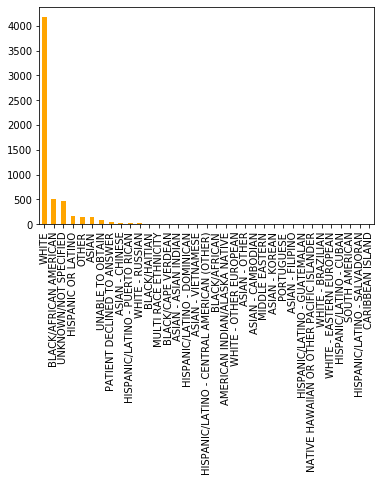

In [88]:
# Visualize 'ETHNICITY' to help transform to a standard format. 
stays_5k['ETHNICITY'].value_counts().plot(kind='bar', color='orange')

### Race Categories
##### American Indian or Alaska Native:
A person having origins in any of the original peoples of North and South America (including Central America), and who maintains tribal affiliation or community attachment.
##### Asian: 
A person having origins in any of the original peoples of the Far East, Southeast Asia, or the Indian subcontinent including, for example, Cambodia, China, India, Japan, Korea, Malaysia, Pakistan, the Philippine Islands, Thailand, and Vietnam.
##### Black or African American: 
A person having origins in any of the black racial groups of Africa. Terms such as "Haitian" ... can be used in addition to "Black or African American".
##### Native Hawaiian or Other Pacific Islander: 
A person having origins in any of the original peoples of Hawaii, Guam, Samoa, or other Pacific Islands.
##### White: 
A person having origins in any of the original peoples of Europe, the Middle East, or North Africa.
##### Hispanic or Latino: 
A person of Cuban, Mexican, Puerto Rican, South or Central American, or other Spanish culture or origin, regardless of race. The term, "Spanish origin", can be used in addition to "Hispanic or Latino".

https://www.iowadatacenter.org/aboutdata/raceclassification

In [89]:
race_map = {'BLACK/AFRICAN AMERICAN' :2, 
 'UNKNOWN/NOT SPECIFIED': 0,
 'HISPANIC OR LATINO' : 3,
 'BLACK/HAITIAN': 2,
 'BLACK/CAPE VERDEAN': 2,
 'WHITE - OTHER EUROPEAN': 4,
 'MULTI RACE ETHNICITY': 5, 
 'WHITE - RUSSIAN': 4, 
 'ASIAN - CHINESE': 1,
 'ASIAN - ASIAN INDIAN': 1,
 'AMERICAN INDIAN/ALASKA NATIVE': 5,
 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)': 3,
 'BLACK/AFRICAN': 2,
 'PORTUGUESE': 4, 
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 5,
 'ASIAN - OTHER': 1,
 'ASIAN - VIETNAMESE': 1, 
 'MIDDLE EASTERN': 4,
 'HISPANIC/LATINO - PUERTO RICAN': 3, 
 'ASIAN - KOREAN': 1,
 'HISPANIC/LATINO - SALVADORAN': 3, 
 'HISPANIC/LATINO - DOMINICAN': 3,
 'WHITE - BRAZILIAN': 4, 
 'HISPANIC/LATINO - GUATEMALAN': 3,
 'ASIAN - FILIPINO': 1, 
 'SOUTH AMERICAN': 3, 
 'WHITE - EASTERN EUROPEAN': 4,
 'HISPANIC/LATINO - CUBAN': 3, 
 'CARIBBEAN ISLAND': 3, 
 'ASIAN - CAMBODIAN': 1,
 'OTHER': 5 }


In [90]:
stays_5k.loc[:, "ETHNICITY"].replace(race_map, inplace=True)

C:\Users\abebu\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


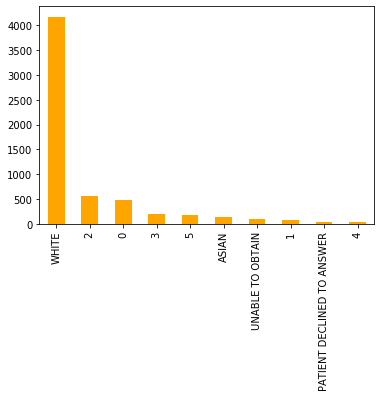

In [91]:
# visualize again to confirm if the transformtion is completed. 
stays_5k['ETHNICITY'].value_counts().plot(kind='bar', color='orange')

In [92]:
stays_5k['ETHNICITY'].unique()

array([2, 'WHITE', 0, 3, 'ASIAN', 'PATIENT DECLINED TO ANSWER', 5,
       'UNABLE TO OBTAIN', 4, 1], dtype=object)

In [93]:
# Further transformation required, remap ethnicity. 
r_map = {2: 'BLACK/AFRICAN AMERICAN',
         'WHITE': 'WHITE',
         0: 'UNKNOWN/NOT SPECIFIED',
         3: 'HISPANIC/LATINO', 
         'ASIAN': 'ASIAN',
         'PATIENT DECLINED TO ANSWER': 'PATIENT DECLINED TO ANSWER', 
         5: 'OTHERS',
         'UNABLE TO OBTAIN': 'UNABLE TO OBTAIN', 
         4: 'WHITE', 
         1: 'ASIAN'}

In [94]:
stays_5k.loc[:, "ETHNICITY"].replace(r_map, inplace=True)

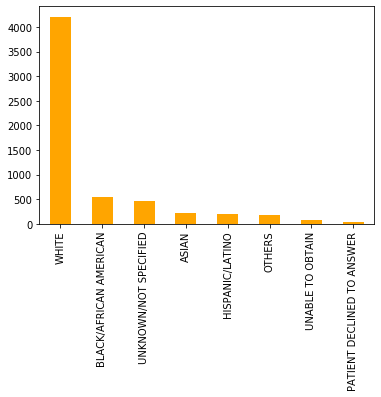

In [95]:
#visualize again to check if everyting looks good. 
stays_5k['ETHNICITY'].value_counts().plot(kind='bar', color='orange')

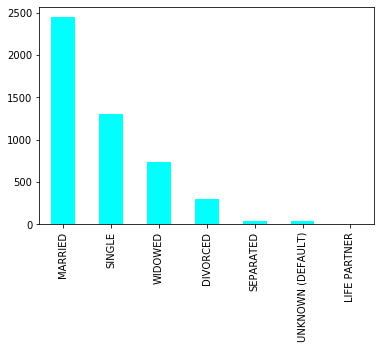

In [96]:
#visualize maritial status 
stays_5k[ 'MARITAL_STATUS'].value_counts().plot(kind='bar', color='cyan')

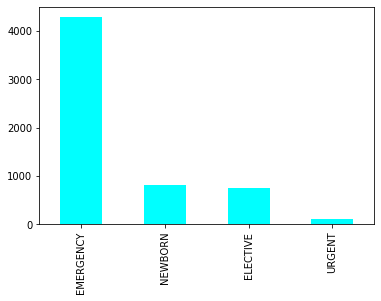

In [97]:
#visualize admission type 
stays_5k[ 'ADMISSION_TYPE'].value_counts().plot(kind='bar', color='cyan')

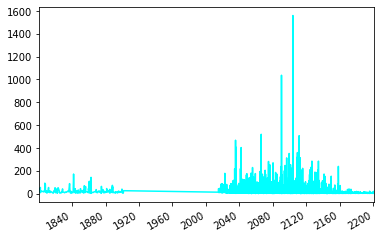

In [69]:
# Create age variable, first review variables that will help to create the age variables
stays_5k['DOB'].value_counts().plot(kind='line', color='cyan')


Patients who are older than 89 years old at any time in the database have had their date of birth shifted to exactly 300 years before their first admission to obscure their age and comply with HIPAA. 

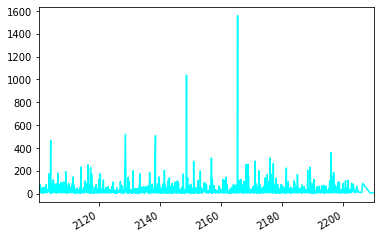

In [70]:
stays_5k['DOD'].value_counts().plot(kind='line', color='cyan')


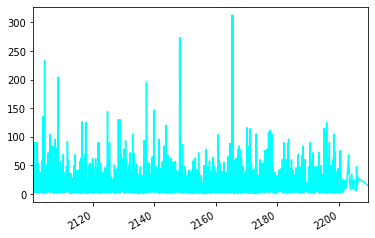

In [71]:
stays_5k['INTIME'].value_counts().plot(kind='line', color='cyan'

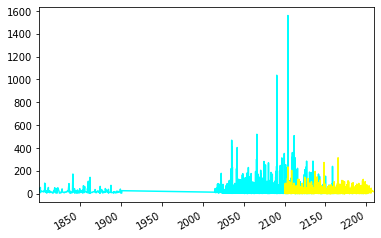

In [72]:
# DOB (Cyan) and ICU admission (yellow)
ax=stays_5k['DOB'].value_counts().plot(kind='line', color='cyan')
stays_5k['INTIME'].value_counts().plot(kind='line', color='yellow')

In [98]:
#Create 'AGE' at time of ICU admission
stays_5k['AGE'] = pd.to_datetime(stays_5k.loc[:, 'INTIME']).dt.date - pd.to_datetime(stays_5k.loc[:, 'DOB']).dt.date
stays_5k['AGE']

C:\Users\abebu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        22690 days, 0:00:00
5        24386 days, 0:00:00
20       24464 days, 0:00:00
71       31727 days, 0:00:00
80                   0:00:00
                ...         
91039    24418 days, 0:00:00
91045    24085 days, 0:00:00
91081    19893 days, 0:00:00
91085    19912 days, 0:00:00
91095    19918 days, 0:00:00
Name: AGE, Length: 5954, dtype: object

In [99]:
# to remove part of the 'AGE' value 'days, 0:00:00' convert the column to string
stays_5k.loc[:, 'AGE']=stays_5k.loc[:, 'AGE'].astype(str)
stays_5k['AGE']

C:\Users\abebu\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0        22690 days, 0:00:00
5        24386 days, 0:00:00
20       24464 days, 0:00:00
71       31727 days, 0:00:00
80                   0:00:00
                ...         
91039    24418 days, 0:00:00
91045    24085 days, 0:00:00
91081    19893 days, 0:00:00
91085    19912 days, 0:00:00
91095    19918 days, 0:00:00
Name: AGE, Length: 5954, dtype: object

In [100]:
#remove part of the 'AGE' value 'days, 0:00:00'
stays_5k['AGE']=stays_5k.loc[:,'AGE'].map(lambda x: x.rstrip(' days, 0:00:00'))
stays_5k['AGE']

C:\Users\abebu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0         2269
5        24386
20       24464
71       31727
80            
         ...  
91039    24418
91045    24085
91081    19893
91085    19912
91095    19918
Name: AGE, Length: 5954, dtype: object

In [103]:
#convert 'AGE' back to numeric, this will allow us to convert from age as number of days to number of years
stays_5k['AGE']=pd.to_numeric(stays_5k.loc[:, 'AGE'], errors='ignore')
stays_5k.AGE.head()

C:\Users\abebu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0      2269.0
5     24386.0
20    24464.0
71    31727.0
80        NaN
Name: AGE, dtype: float64

In [104]:
#convert'AGE' from number of days to number of years
stays_5k['AGE']=stays_5k['AGE']/365

C:\Users\abebu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [105]:
#round the age values to the closest year
stays_5k['AGE'].round()

0         6.0
5        67.0
20       67.0
71       87.0
80        NaN
         ... 
91039    67.0
91045    66.0
91081    55.0
91085    55.0
91095    55.0
Name: AGE, Length: 5954, dtype: float64

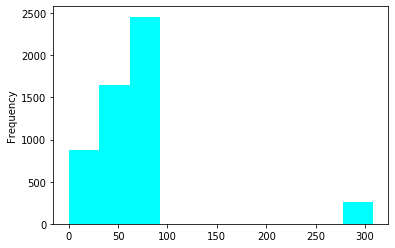

In [446]:
#visualize 'AGE' column
stays_5k['AGE'].plot(kind='hist', color='cyan')

Patients who are older than 89 years old at any time in the database have had their date of birth shifted to exactly 300 years before their first admission to obscure their age and comply with HIPAA. 

In [107]:
# Create a binary column 'CHILD' - YES =1, NO (not a child/Adult) = 0
min_age=18
max_age=np.inf
def condition(value):
    if min_age <= value <= max_age:
        return 0
    return 1
stays_5k['CHILD'] = stays_5k['AGE'].apply(condition)

C:\Users\abebu\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [108]:
stays_5k['CHILD']

0        1
5        0
20       0
71       0
80       1
        ..
91039    0
91045    0
91081    0
91085    0
91095    0
Name: CHILD, Length: 5954, dtype: int64

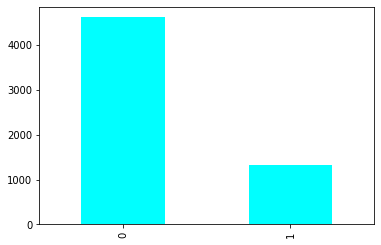

In [109]:
#visualize the newly created 'CHILD' column
stays_5k[ 'CHILD'].value_counts().plot(kind='bar', color='cyan')

In [73]:
# seprate the diagnosis table from stays dataset
dx_5k = stays_5k[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE','CURR_SERVICE']]
dx_5k.shape

(105845, 7)

In [117]:
dx_5k.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE,CURR_SERVICE
0,665,126226,220592.0,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,CMED
1,665,126226,220592.0,42741,Ventricular fibrillation,Ventricular fibrillation,CMED
2,665,126226,220592.0,4111,Intermed coronary synd,Intermediate coronary syndrome,CMED
3,665,126226,220592.0,4254,Prim cardiomyopathy NEC,Other primary cardiomyopathies,CMED
4,665,126226,220592.0,4439,Periph vascular dis NOS,"Peripheral vascular disease, unspecified",CMED


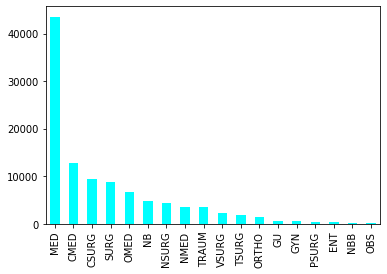

In [124]:
 dx_5k['CURR_SERVICE'].value_counts().plot(kind='bar', color='cyan')

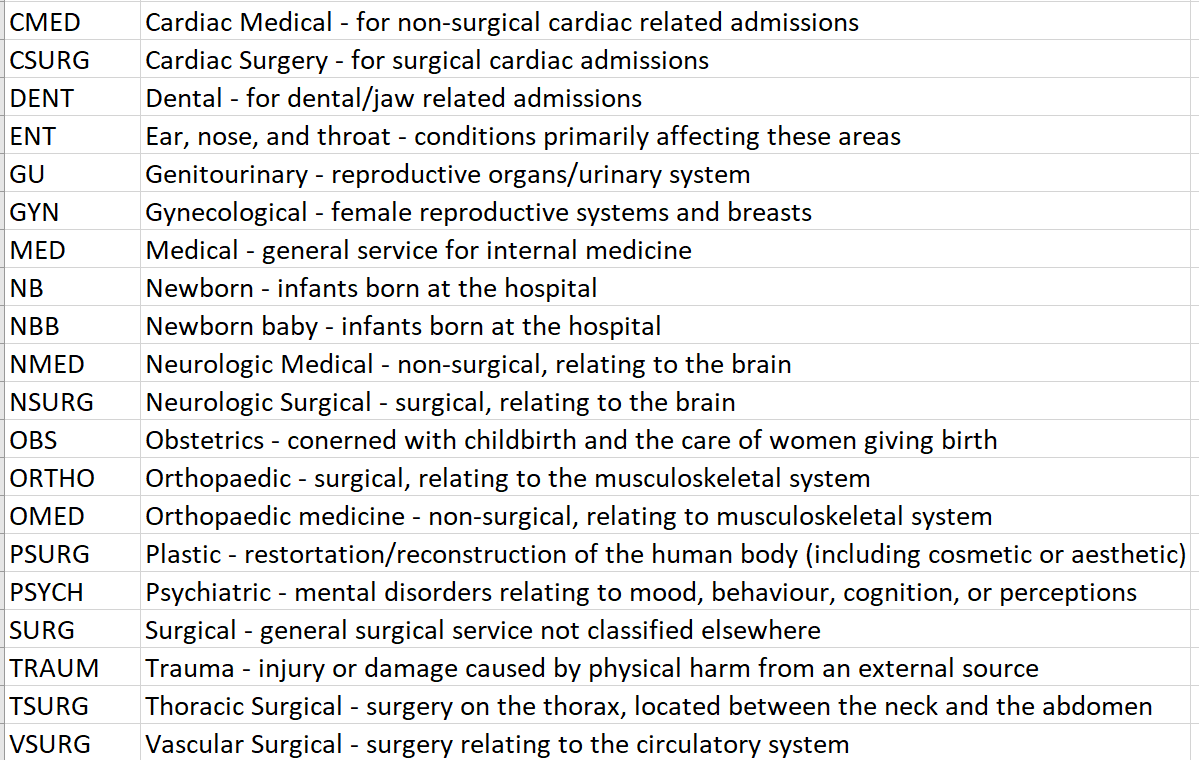

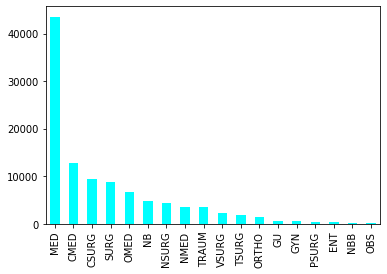

In [179]:
dx_5k['CURR_SERVICE'].value_counts().plot(kind='bar', color='cyan')

In [110]:
list(stays_5k)

['SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'GENDER',
 'DOB',
 'DOD',
 'DOD_HOSP',
 'DOD_SSN',
 'EXPIRE_FLAG',
 'ADMITTIME',
 'DISCHTIME',
 'DEATHTIME',
 'ETHNICITY',
 'MARITAL_STATUS',
 'ADMISSION_TYPE',
 'INSURANCE',
 'DBSOURCE',
 'INTIME',
 'OUTTIME',
 'LOS',
 'MORTALITY',
 'MORTALITY_INHOSPITAL',
 'ICU_DEATH',
 'AGE',
 'CHILD']

In [111]:
# This is the final ICU Stays dataset - lets export it to CSV
stays_5k.to_csv('stays_vF.csv')

In [167]:
icu_stays= stays_5k[['SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'GENDER',
 'EXPIRE_FLAG',
 'ETHNICITY',
 'MARITAL_STATUS',
 'ADMISSION_TYPE',
 'INSURANCE',
 'LOS',
 'MORTALITY',
 'MORTALITY_INHOSPITAL',
 'ICU_DEATH',
 'AGE',
 'CHILD']]

In [7]:
# earlier seprating the diagnosis columns from the stays dataset was a mistake, we need to merge it back
ids=stays_5k[['SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID']]

In [8]:
ids.to_csv('ids.csv')

In [129]:
def stays_merge (table1, table2):
    return table1.merge(table2, how='left', left_on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'], right_on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])

In [130]:
#merge diagnosis table with the ids, so that it can merge with the dx=stays_merge(id, dx_5k)

In [131]:
dx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91119 entries, 0 to 91118
Data columns (total 7 columns):
SUBJECT_ID      91119 non-null int64
HADM_ID         91119 non-null int64
ICUSTAY_ID      91119 non-null float64
ICD9_CODE       91118 non-null object
SHORT_TITLE     88737 non-null object
LONG_TITLE      88737 non-null object
CURR_SERVICE    91094 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 5.6+ MB


In [168]:
icu_stays=stays_merge(icu_stays, dx)

In [171]:
icu_stays.shape

(5954, 20)

In [170]:
#drop if there any duplicates at 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID' level
icu_stays=icu_stays.drop_duplicates (subset=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'], keep='first')

In [172]:
#keep only the final list of research interest columns 
icu_stays=icu_stays[['SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'ICD9_CODE',
 'GENDER',
 'EXPIRE_FLAG',
 'ETHNICITY',
 'MARITAL_STATUS',
 'ADMISSION_TYPE',
 'INSURANCE',
 'LOS',
 'MORTALITY',
 'MORTALITY_INHOSPITAL',
 'ICU_DEATH',
 'AGE',
 'CHILD',
 'CURR_SERVICE']]

In [180]:
icu_stays

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,LOS,MORTALITY,MORTALITY_INHOSPITAL,ICU_DEATH,AGE,CHILD,CURR_SERVICE
0,665,126226,220592.0,41401,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Government,1.0923,0,0,0,6.216438,1,CMED
5,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,0.8693,0,0,0,66.810959,0,MED
20,665,170157,281431.0,56081,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,10.7055,0,0,0,67.024658,0,MED
71,668,166245,231578.0,0389,1,1,WHITE,WIDOWED,EMERGENCY,Medicare,6.3710,0,0,0,86.923288,0,MED
80,696,146163,297527.0,V3000,1,0,WHITE,NaN,NEWBORN,Private,0.0636,0,0,0,NaN,1,NB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91039,44069,138192,214441.0,41401,2,0,WHITE,MARRIED,EMERGENCY,Private,1.1150,0,0,0,66.898630,0,CSURG
91045,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,2.8784,0,0,0,65.986301,0,CMED
91081,44083,125157,265615.0,1510,2,1,WHITE,SINGLE,ELECTIVE,Private,1.9287,0,0,0,54.501370,0,TSURG
91085,44083,131048,282640.0,5119,2,1,WHITE,SINGLE,EMERGENCY,Private,2.1026,0,0,0,54.553425,0,TSURG


In [504]:
list(icu_stays)

['SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'ICD9_CODE',
 'GENDER',
 'EXPIRE_FLAG',
 'ETHNICITY',
 'MARITAL_STATUS',
 'ADMISSION_TYPE',
 'INSURANCE',
 'LOS',
 'MORTALITY',
 'MORTALITY_INHOSPITAL',
 'ICU_DEATH',
 'AGE',
 'CHILD',
 'CURR_SERVICE']

In [503]:
# compared to 'stays_vF.csv' dataset this includes only columns of research interest. 
icu_stays.to_csv('icu_stays.csv')

In [3]:
os.chdir("C://Users/abebu/Google Drive/mimic-iii-clinical-database-1.4/Charts")

In [4]:
# Done with stays dataset. Lets move to Chartevents dataset. First read csv as pandas dataframe.
charts=pd.read_csv('c_c.csv', header=0, index_col=0)
charts.info()

C:\Users\abebu\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6900394 entries, 690 to 4100229
Data columns (total 9 columns):
SUBJECT_ID    int64
HADM_ID       int64
ICUSTAY_ID    float64
ITEMID        int64
CHARTTIME     object
VALUENUM      float64
VALUEUOM      object
LABEL         object
CATEGORY      object
dtypes: float64(2), int64(3), object(4)
memory usage: 526.5+ MB


In [5]:
charts.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
690,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
691,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
692,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
693,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
694,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs


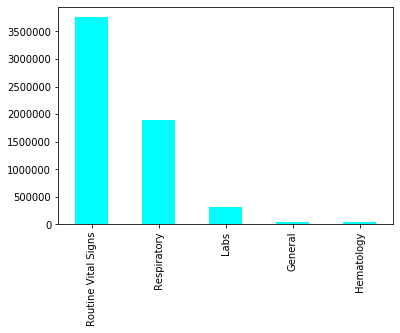

In [5]:
# visualize category column 
charts['CATEGORY'].value_counts().plot(kind='bar', color='cyan')

In [6]:
charts.CATEGORY.unique()

array(['Routine Vital Signs', 'Respiratory', 'Labs', 'General', nan,
       'Hematology'], dtype=object)

In [7]:
# Get a brief look into the units of measurments 'VALUEUOM' colum = units 
charts.VALUEUOM.unique()

array(['mmHg', 'bpm', 'insp/min', '%', 'g/dl', 'K/uL', 'mg/dL', 'mEq/L',
       '?F', '?C', 'kg', 'Inch', 'cm', nan, 'BPM', 'gm/dl'], dtype=object)

In [9]:
# the VALUENUM column is key, if we do not have value the whole record is useless. Lets check if there are null values. 
charts.VALUENUM.isnull().sum()

315

In [10]:
charts = charts.dropna(how='all')

In [11]:
charts.shape # no record (row) was dropped

(6900394, 9)

In [6]:
charts.dropna(how='any', subset=['VALUENUM']) # This removes rows with null values for VALUENUM column (a total of 315 records removed)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
690,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
691,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
692,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
693,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
694,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
...,...,...,...,...,...,...,...,...,...
4100111,32781,142684,294872.0,618,2134-09-27 08:00:00,24.0,BPM,Respiratory Rate,NaN
4100155,32781,142684,294872.0,211,2134-09-26 11:00:00,90.0,BPM,Heart Rate,NaN
4100192,32781,142684,294872.0,211,2134-09-26 20:00:00,79.0,BPM,Heart Rate,NaN
4100208,32781,142684,294872.0,618,2134-09-26 20:00:00,22.0,BPM,Respiratory Rate,NaN


In [13]:
charts.LABEL.isnull().sum()

0

We need to reshape the events data from long to wide, using labels as columns. Before we do that we need to have a clear understanding of what the labels and the units (VALUEUOM) looks like. 

In [14]:
charts.groupby('CATEGORY')['VALUEUOM'].unique()

CATEGORY
General                               [kg, Inch, cm, nan]
Hematology                                   [nan, gm/dl]
Labs                   [g/dl, K/uL, mg/dL, mEq/L, %, nan]
Respiratory                                 [insp/min, %]
Routine Vital Signs                   [mmHg, bpm, ?F, ?C]
Name: VALUEUOM, dtype: object

In [15]:
charts.groupby('CATEGORY')['VALUENUM'].unique()

CATEGORY
General                [77.0, 68.0, 173.0, 76.0, 177.8, 80.8, 53.0, 1...
Hematology             [8.4, 30.2, 11.100000381469727, 9.2, 13.699999...
Labs                   [8.2, 5.0, 101.0, 15.0, 3.7, 44.0, 98.0, 97.0,...
Respiratory            [22.0, 100.0, 25.0, 26.0, 20.0, 17.0, 18.0, 95...
Routine Vital Signs    [126.0, 38.0, 66.0, 75.0, 117.0, 35.0, 61.0, 7...
Name: VALUENUM, dtype: object

nan VALUEUOM doesn't mean nan VALUENUM. Becareful there. 

In [16]:
charts.groupby('CATEGORY')['LABEL'].unique()

CATEGORY
General                [Admission Weight (Kg), Height, Height (cm), D...
Hematology                                             [WBC, Hemoglobin]
Labs                   [Hemoglobin, WBC, BUN, Anion gap, Potassium (s...
Respiratory              [Respiratory Rate, O2 saturation pulseoxymetry]
Routine Vital Signs    [ART BP Systolic, ART BP Diastolic, ART BP mea...
Name: LABEL, dtype: object

this has removed about 150 plus rows.

In [12]:
# Lets list all the unique lebels in the data
charts.LABEL.unique()

[ART BP Systolic, ART BP Diastolic, ART BP mean, Heart Rate, Respiratory Rate, ..., Daily Weight, Arterial Blood Pressure systolic, Arterial Blood Pressure diastolic, Arterial Blood Pressure mean, Admission Weight (lbs.)]
Length: 26
Categories (26, object): [ART BP Systolic, ART BP Diastolic, ART BP mean, Heart Rate, ..., Arterial Blood Pressure systolic, Arterial Blood Pressure diastolic, Arterial Blood Pressure mean, Admission Weight (lbs.)]

In [7]:
list(charts)

['SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'ITEMID',
 'CHARTTIME',
 'VALUENUM',
 'VALUEUOM',
 'LABEL',
 'CATEGORY']

In [8]:
charts['LABEL'] = charts['LABEL'].astype('category')

In [11]:
charts['LABEL'].cat.set_categories(['ART BP Systolic', 'ART BP Diastolic', 'ART BP mean', 'Heart Rate',
       'Respiratory Rate', 'O2 saturation pulseoxymetry', 'Hemoglobin',
       'WBC', 'BUN', 'Anion gap', 'Potassium (serum)', 'Platelet Count',
       'Arterial O2 Saturation', 'Non Invasive Blood Pressure systolic',
       'Non Invasive Blood Pressure diastolic',
       'Non Invasive Blood Pressure mean', 'Temperature Fahrenheit',
       'Temperature Celsius', 'Admission Weight (Kg)', 'Height',
       'Height (cm)', 'Daily Weight', 'Arterial Blood Pressure systolic',
       'Arterial Blood Pressure diastolic',
       'Arterial Blood Pressure mean', 'Admission Weight (lbs.)'], inplace=True) 

In [10]:
charts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6900394 entries, 690 to 4100229
Data columns (total 9 columns):
SUBJECT_ID    int64
HADM_ID       int64
ICUSTAY_ID    float64
ITEMID        int64
CHARTTIME     object
VALUENUM      float64
VALUEUOM      object
LABEL         category
CATEGORY      object
dtypes: category(1), float64(2), int64(3), object(3)
memory usage: 480.4+ MB


In [20]:
charts.set_index('LABEL')

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,CATEGORY
LABEL,,,,,,,,
ART BP Systolic,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,Routine Vital Signs
ART BP Systolic,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,Routine Vital Signs
ART BP Systolic,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,Routine Vital Signs
ART BP Systolic,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,Routine Vital Signs
ART BP Systolic,124,138376,256064.0,225309,2166-01-16 12:00:00,126.0,mmHg,Routine Vital Signs
...,...,...,...,...,...,...,...,...
Respiratory Rate,32781,142684,294872.0,618,2134-09-27 08:00:00,24.0,BPM,NaN
Heart Rate,32781,142684,294872.0,211,2134-09-26 11:00:00,90.0,BPM,NaN
Heart Rate,32781,142684,294872.0,211,2134-09-26 20:00:00,79.0,BPM,NaN


In [48]:
# read csv as pandas dataframe
icu=pd.read_csv('icu_stays.csv', header=0, index_col=0)
icu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5954 entries, 0 to 91095
Data columns (total 17 columns):
SUBJECT_ID              5954 non-null int64
HADM_ID                 5954 non-null int64
ICUSTAY_ID              5954 non-null float64
ICD9_CODE               5953 non-null object
GENDER                  5954 non-null int64
EXPIRE_FLAG             5954 non-null int64
ETHNICITY               5954 non-null object
MARITAL_STATUS          4875 non-null object
ADMISSION_TYPE          5954 non-null object
INSURANCE               5954 non-null object
LOS                     5954 non-null float64
MORTALITY               5954 non-null int64
MORTALITY_INHOSPITAL    5954 non-null int64
ICU_DEATH               5954 non-null int64
AGE                     5239 non-null float64
CHILD                   5954 non-null int64
CURR_SERVICE            5952 non-null object
dtypes: float64(3), int64(8), object(6)
memory usage: 837.3+ KB


In [49]:
icu.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,LOS,MORTALITY,MORTALITY_INHOSPITAL,ICU_DEATH,AGE,CHILD,CURR_SERVICE
0,665,126226,220592.0,41401,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Government,1.0923,0,0,0,6.216438,1,CMED
5,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,0.8693,0,0,0,66.810959,0,MED
20,665,170157,281431.0,56081,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,10.7055,0,0,0,67.024658,0,MED
71,668,166245,231578.0,0389,1,1,WHITE,WIDOWED,EMERGENCY,Medicare,6.3710,0,0,0,86.923288,0,MED
80,696,146163,297527.0,V3000,1,0,WHITE,NaN,NEWBORN,Private,0.0636,0,0,0,NaN,1,NB


In [50]:
# Create final dataset. Merge stays and events
list (icu)

['SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'ICD9_CODE',
 'GENDER',
 'EXPIRE_FLAG',
 'ETHNICITY',
 'MARITAL_STATUS',
 'ADMISSION_TYPE',
 'INSURANCE',
 'LOS',
 'MORTALITY',
 'MORTALITY_INHOSPITAL',
 'ICU_DEATH',
 'AGE',
 'CHILD',
 'CURR_SERVICE']

In [51]:
list(charts)

['SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'ITEMID',
 'CHARTTIME',
 'VALUENUM',
 'VALUEUOM',
 'LABEL',
 'CATEGORY']

In [57]:
def se_merge (table1, table2):
    return table1.merge(table2, how='inner', left_on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'], right_on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])

In [58]:
#the final dataset 
cd = se_merge(icu, charts)

In [54]:
list(cd)

['SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'ICD9_CODE',
 'GENDER',
 'EXPIRE_FLAG',
 'ETHNICITY',
 'MARITAL_STATUS',
 'ADMISSION_TYPE',
 'INSURANCE',
 'LOS',
 'MORTALITY',
 'MORTALITY_INHOSPITAL',
 'ICU_DEATH',
 'AGE',
 'CHILD',
 'CURR_SERVICE',
 'ITEMID',
 'CHARTTIME',
 'VALUENUM',
 'VALUEUOM',
 'LABEL',
 'CATEGORY']

In [59]:
cd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6900394 entries, 0 to 6900393
Data columns (total 23 columns):
SUBJECT_ID              int64
HADM_ID                 int64
ICUSTAY_ID              float64
ICD9_CODE               object
GENDER                  int64
EXPIRE_FLAG             int64
ETHNICITY               object
MARITAL_STATUS          object
ADMISSION_TYPE          object
INSURANCE               object
LOS                     float64
MORTALITY               int64
MORTALITY_INHOSPITAL    int64
ICU_DEATH               int64
AGE                     float64
CHILD                   int64
CURR_SERVICE            object
ITEMID                  int64
CHARTTIME               object
VALUENUM                float64
VALUEUOM                object
LABEL                   category
CATEGORY                object
dtypes: category(1), float64(4), int64(9), object(9)
memory usage: 1.2+ GB


In [56]:
cd.to_csv('cd.csv')

In [5]:
cd=pd.read_csv('cd.csv', header=0, index_col=0)
cd.info()

C:\Users\abebu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\abebu\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6900499 entries, 0 to 6900498
Data columns (total 23 columns):
SUBJECT_ID              int64
HADM_ID                 int64
ICUSTAY_ID              float64
ICD9_CODE               object
GENDER                  int64
EXPIRE_FLAG             int64
ETHNICITY               object
MARITAL_STATUS          object
ADMISSION_TYPE          object
INSURANCE               object
LOS                     float64
MORTALITY               int64
MORTALITY_INHOSPITAL    int64
ICU_DEATH               int64
AGE                     float64
CHILD                   int64
CURR_SERVICE            object
ITEMID                  float64
CHARTTIME               object
VALUENUM                float64
VALUEUOM                object
LABEL                   object
CATEGORY                object
dtypes: float64(5), int64(8), object(10)
memory usage: 1.2+ GB


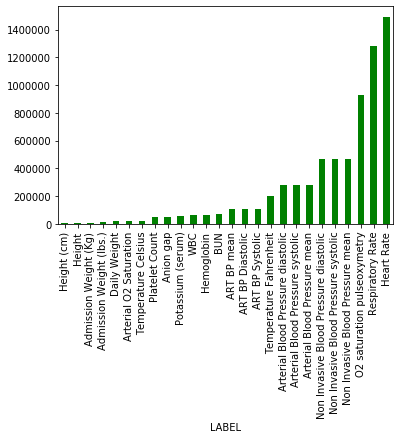

In [6]:
#Now lets reshpe the file using pivot

cd.groupby("LABEL")['VALUENUM'].count().sort_values().plot(kind='bar', color='green')

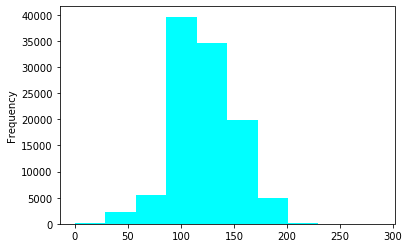

In [8]:
#Now lets reshpe the file using pivot
art=cd[cd['LABEL']=='ART BP Systolic']
art['VALUENUM'].plot(kind='hist', color='cyan')

I selected charts events relevant to the Early Warning System (EWS) Scores. EWS scores are used by hospital care teams to recognize early signs of clinical deterioration and trigger more intensive care.

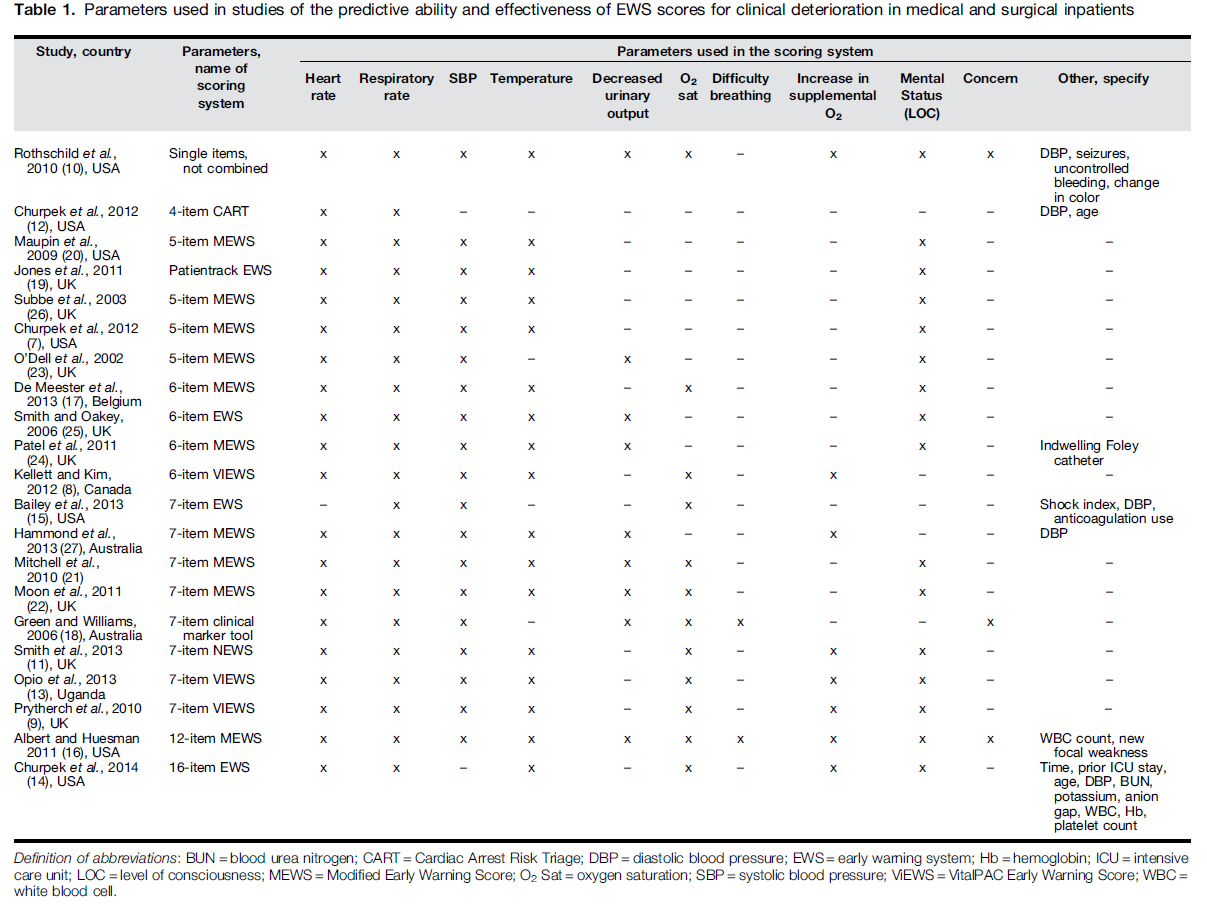
source: https://www.atsjournals.org/doi/pdf/10.1513/AnnalsATS.201403-102OC

SBP = ['ART BP Systolic'], systolic blood pressure; there is also another LABEL var ['Arterial Blood Pressure diastolic', 'Arterial Blood Pressure systolic]
DBP = ['ART BP Diastolic'], diastolic blood pressure; 
Decreased urinary output (this data need to be pulled from the The outputevents table), 
O2 sat = ['Arterial O2 Saturation']
Increase in supplemental O2 = ['O2 saturation pulseoxymetry']??
hb = ['Hemoglobin']
platelet count = ['Platelet Count']

### Converstions and other inconsistancies

Height (inch
Height (cm)

Temperature Celsius
Temperature Fahrenheit

Admission Weight (Kg)
Admission Weight (lbs.)

Arterial Blood Pressure diastolic
Arterial Blood Pressure mean
Arterial Blood Pressure systolic

ART BP Diastolic
ART BP Systolic
ART BP mean

Non Invasive Blood Pressure diastolic
Non Invasive Blood Pressure mean
Non Invasive Blood Pressure systolic

Potassium (serum)
Potassium (whole blood)



In [12]:
# convert Height (in label) to cm
cd[cd.LABEL.isin(['Height', 'Height (cm)'])]
cd.loc[cd.LABEL== 'Height', 'VALUENUM'] = (cd.VALUENUM *2.54)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,...,ICU_DEATH,AGE,CHILD,CURR_SERVICE,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
5515,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226707.0,2119-02-26 14:29:00,154.94,Inch,Height,General
5516,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226707.0,2119-02-26 14:29:00,154.94,Inch,Height,General
5517,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226707.0,2119-02-26 14:29:00,154.94,Inch,Height,General
5518,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226707.0,2119-02-26 14:29:00,154.94,Inch,Height,General
5519,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226707.0,2119-02-26 14:29:00,154.94,Inch,Height,General
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6899156,44083,125157,265615.0,1510,2,1,WHITE,SINGLE,ELECTIVE,Private,...,0,54.501370,0,TSURG,226730.0,2112-05-06 12:27:00,173.00,cm,Height (cm),General
6899724,44083,131048,282640.0,5119,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.553425,0,TSURG,226707.0,2112-05-23 13:31:00,157.48,Inch,Height,General
6899725,44083,131048,282640.0,5119,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.553425,0,TSURG,226730.0,2112-05-23 13:31:00,157.00,cm,Height (cm),General
6900014,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,226707.0,2112-05-29 02:08:00,172.72,Inch,Height,General


In [13]:
# now that both Height and Height (cm) have the same unit, lets make sure they have the same label name. 
cd['LABEL'].mask(cd['LABEL']=='Height (cm)', 'Height', inplace=True)
cd[cd.LABEL.isin(['Height'])]

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,...,ICU_DEATH,AGE,CHILD,CURR_SERVICE,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
5515,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226707.0,2119-02-26 14:29:00,154.94,Inch,Height,General
5516,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226707.0,2119-02-26 14:29:00,154.94,Inch,Height,General
5517,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226707.0,2119-02-26 14:29:00,154.94,Inch,Height,General
5518,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226707.0,2119-02-26 14:29:00,154.94,Inch,Height,General
5519,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226707.0,2119-02-26 14:29:00,154.94,Inch,Height,General
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6899156,44083,125157,265615.0,1510,2,1,WHITE,SINGLE,ELECTIVE,Private,...,0,54.501370,0,TSURG,226730.0,2112-05-06 12:27:00,173.00,cm,Height,General
6899724,44083,131048,282640.0,5119,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.553425,0,TSURG,226707.0,2112-05-23 13:31:00,157.48,Inch,Height,General
6899725,44083,131048,282640.0,5119,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.553425,0,TSURG,226730.0,2112-05-23 13:31:00,157.00,cm,Height,General
6900014,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,226707.0,2112-05-29 02:08:00,172.72,Inch,Height,General


In [15]:
# convert from Temperature Celsius Temperature Fahrenheit
cd[cd.LABEL.isin(['Temperature Celsius', 'Temperature Fahrenheit'])]
cd.loc[cd.LABEL== 'Temperature Fahrenheit', 'VALUENUM'] = ((cd.VALUENUM -32) * 5./9)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,...,ICU_DEATH,AGE,CHILD,CURR_SERVICE,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
76,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,223761.0,2119-02-25 23:00:00,36.166667,?F,Temperature Fahrenheit,Routine Vital Signs
77,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,223761.0,2119-02-25 23:00:00,36.166667,?F,Temperature Fahrenheit,Routine Vital Signs
78,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,223761.0,2119-02-25 23:00:00,36.166667,?F,Temperature Fahrenheit,Routine Vital Signs
79,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,223761.0,2119-02-25 23:00:00,36.166667,?F,Temperature Fahrenheit,Routine Vital Signs
80,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,223761.0,2119-02-25 23:00:00,36.166667,?F,Temperature Fahrenheit,Routine Vital Signs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6900372,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,223761.0,2112-05-30 19:00:00,36.666667,?F,Temperature Fahrenheit,Routine Vital Signs
6900425,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,223761.0,2112-05-31 20:00:00,37.000000,?F,Temperature Fahrenheit,Routine Vital Signs
6900444,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,223761.0,2112-05-29 08:00:00,36.666667,?F,Temperature Fahrenheit,Routine Vital Signs
6900469,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,223761.0,2112-06-01 00:00:00,37.111111,?F,Temperature Fahrenheit,Routine Vital Signs


In [17]:
# now that both 'Temperature Fahrenheit', 'Temperature Celsius' have the same unit, lets make sure they have the same label name. 
cd['LABEL'].mask(cd['LABEL']== 'Temperature Fahrenheit', 'Temperature Celsius', inplace=True)
cd['VALUEUOM'].mask(cd['VALUEUOM']== '?F', 'Celsius', inplace=True)
cd[cd.LABEL.isin(['Temperature Celsius'])]

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,...,ICU_DEATH,AGE,CHILD,CURR_SERVICE,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
76,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,223761.0,2119-02-25 23:00:00,36.166667,Celsius,Temperature Celsius,Routine Vital Signs
77,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,223761.0,2119-02-25 23:00:00,36.166667,Celsius,Temperature Celsius,Routine Vital Signs
78,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,223761.0,2119-02-25 23:00:00,36.166667,Celsius,Temperature Celsius,Routine Vital Signs
79,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,223761.0,2119-02-25 23:00:00,36.166667,Celsius,Temperature Celsius,Routine Vital Signs
80,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,223761.0,2119-02-25 23:00:00,36.166667,Celsius,Temperature Celsius,Routine Vital Signs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6900372,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,223761.0,2112-05-30 19:00:00,36.666667,Celsius,Temperature Celsius,Routine Vital Signs
6900425,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,223761.0,2112-05-31 20:00:00,37.000000,Celsius,Temperature Celsius,Routine Vital Signs
6900444,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,223761.0,2112-05-29 08:00:00,36.666667,Celsius,Temperature Celsius,Routine Vital Signs
6900469,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,223761.0,2112-06-01 00:00:00,37.111111,Celsius,Temperature Celsius,Routine Vital Signs


In [18]:
cd.LABEL.unique()

array(['Heart Rate', 'Respiratory Rate', 'BUN', 'WBC', 'Hemoglobin',
       'Temperature Celsius', 'Non Invasive Blood Pressure systolic',
       'Non Invasive Blood Pressure diastolic',
       'Non Invasive Blood Pressure mean', 'O2 saturation pulseoxymetry',
       'Anion gap', 'Potassium (serum)', 'Platelet Count',
       'Admission Weight (lbs.)', 'Admission Weight (Kg)', 'Height',
       'Arterial O2 Saturation', 'Arterial Blood Pressure systolic',
       'Arterial Blood Pressure diastolic',
       'Arterial Blood Pressure mean', 'Daily Weight', 'ART BP Systolic',
       'ART BP Diastolic', 'ART BP mean', nan], dtype=object)

In [20]:
# Convert weight in lbs to kg
cd[cd.LABEL.isin(['Admission Weight (Kg)', 'Admission Weight (lbs.)'])]
cd.loc[cd.LABEL== 'Admission Weight (lbs.)', 'VALUENUM'] = (cd.VALUENUM * 0.453592)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,...,ICU_DEATH,AGE,CHILD,CURR_SERVICE,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
3702,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226531.0,2119-02-26 08:06:00,55.882534,NaN,Admission Weight (lbs.),General
3703,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226531.0,2119-02-26 08:06:00,55.882534,NaN,Admission Weight (lbs.),General
3704,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226531.0,2119-02-26 08:06:00,55.882534,NaN,Admission Weight (lbs.),General
3705,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226531.0,2119-02-26 08:06:00,55.882534,NaN,Admission Weight (lbs.),General
3706,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226531.0,2119-02-26 08:06:00,55.882534,NaN,Admission Weight (lbs.),General
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6899723,44083,131048,282640.0,5119,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.553425,0,TSURG,226512.0,2112-05-23 13:31:00,98.600000,kg,Admission Weight (Kg),General
6899849,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,226531.0,2112-05-29 20:35:00,99.382007,NaN,Admission Weight (lbs.),General
6900012,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,226531.0,2112-05-29 02:06:00,99.382007,NaN,Admission Weight (lbs.),General
6900013,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,226512.0,2112-05-29 02:08:00,99.600000,kg,Admission Weight (Kg),General


In [24]:
cd['LABEL'].mask(cd['LABEL']== 'Admission Weight (lbs.)', 'Admission Weight (Kg)', inplace=True)
cd.VALUEUOM.fillna('kg', inplace=True)
cd[cd.LABEL.isin(['Admission Weight (Kg)'])]

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,...,ICU_DEATH,AGE,CHILD,CURR_SERVICE,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
3702,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226531.0,2119-02-26 08:06:00,55.882534,kg,Admission Weight (Kg),General
3703,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226531.0,2119-02-26 08:06:00,55.882534,kg,Admission Weight (Kg),General
3704,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226531.0,2119-02-26 08:06:00,55.882534,kg,Admission Weight (Kg),General
3705,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226531.0,2119-02-26 08:06:00,55.882534,kg,Admission Weight (Kg),General
3706,665,152089,220843.0,4589,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Medicaid,...,0,66.810959,0,MED,226531.0,2119-02-26 08:06:00,55.882534,kg,Admission Weight (Kg),General
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6899723,44083,131048,282640.0,5119,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.553425,0,TSURG,226512.0,2112-05-23 13:31:00,98.600000,kg,Admission Weight (Kg),General
6899849,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,226531.0,2112-05-29 20:35:00,99.382007,kg,Admission Weight (Kg),General
6900012,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,226531.0,2112-05-29 02:06:00,99.382007,kg,Admission Weight (Kg),General
6900013,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,226512.0,2112-05-29 02:08:00,99.600000,kg,Admission Weight (Kg),General


In [25]:
cd

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,...,ICU_DEATH,AGE,CHILD,CURR_SERVICE,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
0,665,126226,220592.0,41401,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Government,...,0,6.216438,1,CMED,211.0,2114-07-06 07:00:00,67.000000,BPM,Heart Rate,NaN
1,665,126226,220592.0,41401,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Government,...,0,6.216438,1,CMED,618.0,2114-07-06 07:00:00,20.000000,BPM,Respiratory Rate,NaN
2,665,126226,220592.0,41401,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Government,...,0,6.216438,1,CMED,211.0,2114-07-06 08:00:00,65.000000,BPM,Heart Rate,NaN
3,665,126226,220592.0,41401,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Government,...,0,6.216438,1,CMED,618.0,2114-07-06 08:00:00,21.000000,BPM,Respiratory Rate,NaN
4,665,126226,220592.0,41401,2,1,BLACK/AFRICAN AMERICAN,SINGLE,EMERGENCY,Government,...,0,6.216438,1,CMED,211.0,2114-07-06 09:00:00,69.000000,BPM,Heart Rate,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6900494,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,220180.0,2112-05-29 20:00:00,64.000000,mmHg,Non Invasive Blood Pressure diastolic,Routine Vital Signs
6900495,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,220181.0,2112-05-29 20:00:00,80.000000,mmHg,Non Invasive Blood Pressure mean,Routine Vital Signs
6900496,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,220210.0,2112-05-29 20:00:00,22.000000,insp/min,Respiratory Rate,Respiratory
6900497,44083,198330,286428.0,4239,2,1,WHITE,SINGLE,EMERGENCY,Private,...,0,54.569863,0,CMED,220277.0,2112-05-29 20:00:00,98.000000,%,O2 saturation pulseoxymetry,Respiratory


#### The following three trios of variables look the same, this need to be solved. 

['Arterial Blood Pressure diastolic'], 
['Arterial Blood Pressure systolic'], 
['Arterial Blood Pressure mean'], 


['ART BP Diastolic'], ['ART BP Systolic'], 
['ART BP mean'],

['Non Invasive Blood Pressure diastolic'], 
['Non Invasive Blood Pressure systolic'], 
['Non Invasive Blood Pressure mean']

In [26]:
cd[cd.LABEL.isin(['Arterial Blood Pressure diastolic',  
'ART BP Diastolic', 
'Non Invasive Blood Pressure diastolic'])]
cd.LABEL.fillna ('ART BP Diastolic')
#cd.VALUEUOM.fillna('mmHg', inplace=True) # this is not necessary as all have the same unit (mmHg)
cd[cd.LABEL.isin(['ART BP Diastolic'])]

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,...,ICU_DEATH,AGE,CHILD,CURR_SERVICE,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
226023,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225310.0,2166-01-16 12:00:00,38.0,mmHg,ART BP Diastolic,Routine Vital Signs
226024,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225310.0,2166-01-16 12:00:00,38.0,mmHg,ART BP Diastolic,Routine Vital Signs
226025,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225310.0,2166-01-16 12:00:00,38.0,mmHg,ART BP Diastolic,Routine Vital Signs
226026,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225310.0,2166-01-16 12:00:00,38.0,mmHg,ART BP Diastolic,Routine Vital Signs
226027,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225310.0,2166-01-16 12:00:00,38.0,mmHg,ART BP Diastolic,Routine Vital Signs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6898965,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225310.0,2122-04-08 09:00:00,63.0,mmHg,ART BP Diastolic,Routine Vital Signs
6899077,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225310.0,2122-04-07 22:42:00,49.0,mmHg,ART BP Diastolic,Routine Vital Signs
6899089,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225310.0,2122-04-07 23:00:00,50.0,mmHg,ART BP Diastolic,Routine Vital Signs
6899096,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225310.0,2122-04-08 00:00:00,53.0,mmHg,ART BP Diastolic,Routine Vital Signs


In [27]:
cd[cd.LABEL.isin(['Arterial Blood Pressure systolic', 
'ART BP Systolic', 
'Non Invasive Blood Pressure systolic'])]
cd.LABEL.fillna ('ART BP Systolic')
#cd.VALUEUOM.fillna('mmHg', inplace=True) # this is not necessary as all have the same unit (mmHg)
cd[cd.LABEL.isin(['ART BP Systolic'])]

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,...,ICU_DEATH,AGE,CHILD,CURR_SERVICE,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
225885,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225309.0,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
225886,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225309.0,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
225887,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225309.0,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
225888,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225309.0,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
225889,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225309.0,2166-01-16 12:00:00,126.0,mmHg,ART BP Systolic,Routine Vital Signs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6898964,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225309.0,2122-04-08 09:00:00,144.0,mmHg,ART BP Systolic,Routine Vital Signs
6899076,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225309.0,2122-04-07 22:42:00,112.0,mmHg,ART BP Systolic,Routine Vital Signs
6899088,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225309.0,2122-04-07 23:00:00,112.0,mmHg,ART BP Systolic,Routine Vital Signs
6899095,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225309.0,2122-04-08 00:00:00,129.0,mmHg,ART BP Systolic,Routine Vital Signs


In [28]:
cd[cd.LABEL.isin(['Arterial Blood Pressure mean', 
'ART BP mean',
'Non Invasive Blood Pressure mean'])]

cd.LABEL.fillna ('ART BP mean')
#cd.VALUEUOM.fillna('mmHg', inplace=True) # this is not necessary as all have the same unit (mmHg)
cd[cd.LABEL.isin(['ART BP mean'])]

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,GENDER,EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,ADMISSION_TYPE,INSURANCE,...,ICU_DEATH,AGE,CHILD,CURR_SERVICE,ITEMID,CHARTTIME,VALUENUM,VALUEUOM,LABEL,CATEGORY
226161,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225312.0,2166-01-16 12:00:00,66.0,mmHg,ART BP mean,Routine Vital Signs
226162,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225312.0,2166-01-16 12:00:00,66.0,mmHg,ART BP mean,Routine Vital Signs
226163,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225312.0,2166-01-16 12:00:00,66.0,mmHg,ART BP mean,Routine Vital Signs
226164,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225312.0,2166-01-16 12:00:00,66.0,mmHg,ART BP mean,Routine Vital Signs
226165,124,138376,256064.0,56983,2,1,WHITE,MARRIED,EMERGENCY,Medicare,...,1,75.189041,0,MED,225312.0,2166-01-16 12:00:00,66.0,mmHg,ART BP mean,Routine Vital Signs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6898966,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225312.0,2122-04-08 09:00:00,100.0,mmHg,ART BP mean,Routine Vital Signs
6899078,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225312.0,2122-04-07 22:42:00,89.0,mmHg,ART BP mean,Routine Vital Signs
6899090,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225312.0,2122-04-07 23:00:00,88.0,mmHg,ART BP mean,Routine Vital Signs
6899097,44082,178322,233193.0,41071,1,0,WHITE,DIVORCED,EMERGENCY,Medicare,...,0,65.986301,0,CMED,225312.0,2122-04-08 00:00:00,98.0,mmHg,ART BP mean,Routine Vital Signs


In [29]:
cd.to_csv('cd_vf.csv')

In [30]:
list(cd)

['SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'ICD9_CODE',
 'GENDER',
 'EXPIRE_FLAG',
 'ETHNICITY',
 'MARITAL_STATUS',
 'ADMISSION_TYPE',
 'INSURANCE',
 'LOS',
 'MORTALITY',
 'MORTALITY_INHOSPITAL',
 'ICU_DEATH',
 'AGE',
 'CHILD',
 'CURR_SERVICE',
 'ITEMID',
 'CHARTTIME',
 'VALUENUM',
 'VALUEUOM',
 'LABEL',
 'CATEGORY']

#### Visualize all final list of events columns 

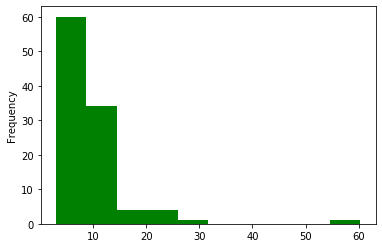

In [57]:
p_events['WBC'].plot(kind='hist', color='green')

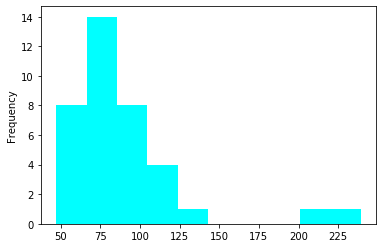

In [58]:
p_events['Daily Weight'].plot(kind='hist', color='cyan')

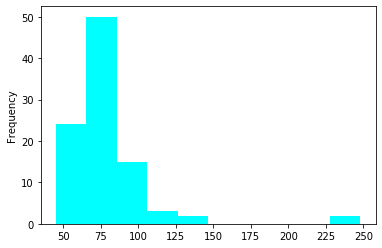

In [59]:
p_events['Admission Weight (Kg)'].plot(kind='hist', color='cyan')

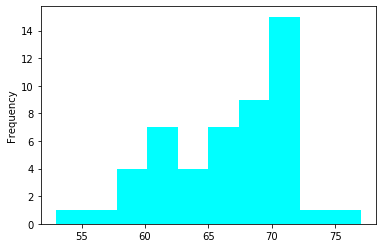

In [60]:
p_events['Height'].plot(kind='hist', color='cyan')

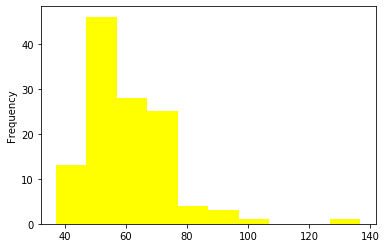

In [61]:
p_events['ART BP Diastolic'].plot(kind='hist', color='yellow')

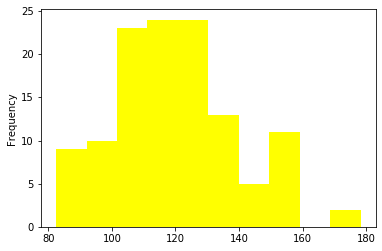

In [418]:
p_events['ART BP Systolic'].plot(kind='hist', color='yellow')

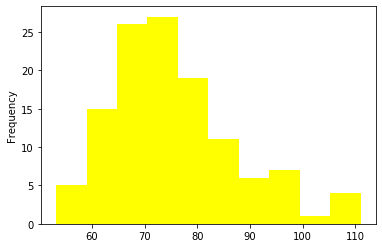

In [419]:
p_events['ART BP mean'].plot(kind='hist', color='yellow')

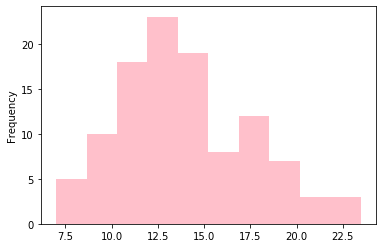

In [420]:
p_events['Anion gap'].plot(kind='hist', color='pink')

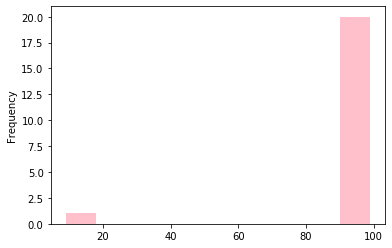

In [422]:
p_events['Arterial O2 Saturation'].plot(kind='hist', color='pink')

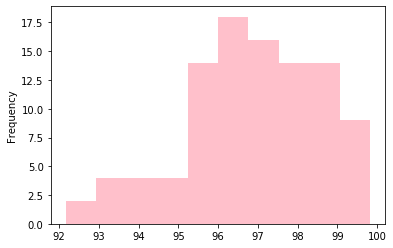

In [436]:
p_events['O2 saturation pulseoxymetry'].plot(kind='hist', color='pink')

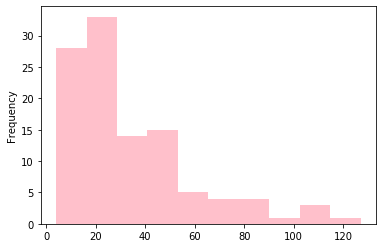

In [424]:
#Blood Urea Nitrogine 
p_events['BUN'].plot(kind='hist', color='pink')

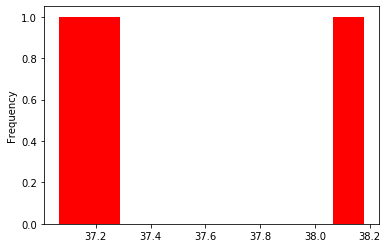

In [425]:
p_events['Blood Temperature CCO (C)'].plot(kind='hist', color='red')

In [427]:
del p_events['Blood Temperature CCO (C)']

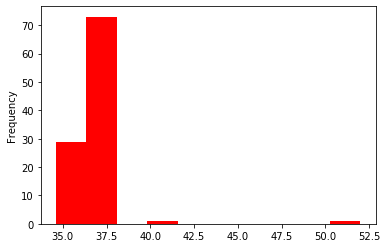

In [426]:
p_events['Temperature Celsius'].plot(kind='hist', color='red')

In [428]:
#pivot_events=events.pivot_table(values='VALUE', index=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTS_ITEMID','VALUEUOM'], columns='LABEL')

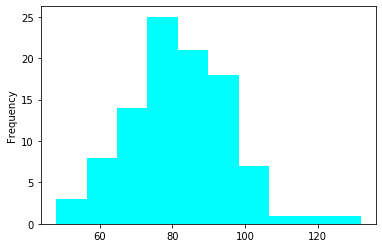

In [434]:
p_events['Heart Rate'].plot(kind='hist', color='cyan')

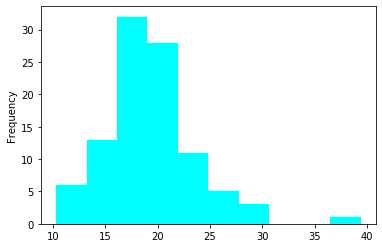

In [438]:
p_events['Respiratory Rate'].plot(kind='hist', color='cyan')

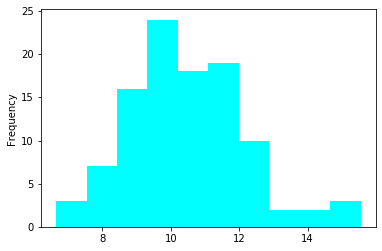

In [435]:
p_events['Hemoglobin'].plot(kind='hist', color='cyan')

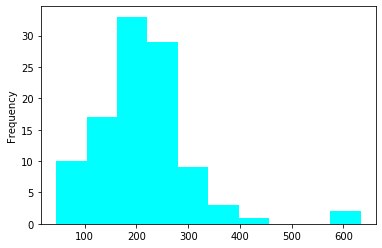

In [437]:
p_events['Platelet Count'].plot(kind='hist', color='cyan')

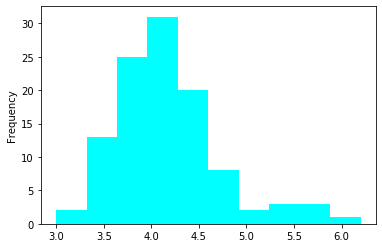

In [439]:
p_events['Potassium (serum)'].plot(kind='hist', color='cyan')

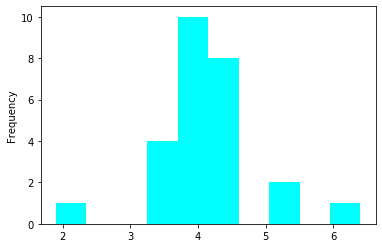

In [440]:
p_events['Potassium (whole blood)'].plot(kind='hist', color='cyan')

In [441]:
#The data on serum based test is more reliable. Delete the whole blod test column 
del p_events['Potassium (whole blood)']

In [444]:
#export and save the final list of events data
p_events.to_csv('pivot_events_vf.csv')

There is one variable (Urine output) that might be interest of research from the outputs table. Lets try to pull it and merge with the events data. 